# **Siamese Network using face dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Load data:**

In [ ]:
!unzip /content/gdrive/Shareddrives/data_face_HUS/data_face_HUS.zip -d "/content/"

**Import all neeeded libraries and preprocess**

In [ ]:
import os
import glob
import cv2
import numpy as np

folder_path = 'data_face_HUS/*/*'

# Find all files in subfolders
files = glob.glob(folder_path, recursive=True)

X_train_label = []
X_train_list = []
X_test_label = []
X_test_list = []
for category, files in files.items():
    train_list = glob.glob('data_face_HUS/'+category+'/*')
    for name in train_list:
        img = cv2.imread(name)
        img = cv2.resize(img,(96,96))
        X_train_list.append(img)
        X_train_label.append(category)

**Divide into train and test**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)

**Build model CNN**

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

inp = Input(shape=(96,96,1))
x = Conv2D(filters = 8, kernel_size = 3, activation = 'relu')(inp)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Flatten()(x)
x = Dense(units = 32, activation = 'relu')(x)
x = Dense(units = 2)(x)

cnn = Model(inputs = inp, outputs = x)
img1 = Input(shape = (96,96,1))
img2 = Input(shape = (96,96,1))

f1 = cnn(img1)
f2 = cnn(img2)

d = K.sqrt(K.sum(K.square(f1 - f2),axis = 1, keepdims = True))

model = Model(inputs = [img1,img2], outputs = d)
model.summary()
cnn.summary()

def loss(y_true, y_pred):
  proba = K.exp(-K.square(y_pred))
  return -K.mean(y_true * K.log(proba) + (1-y_true) * K.log(1-proba))

def loss1(y_true, y_pred):
  return K.mean(y_true * K.square(y_pred) + (1-y_true) * K.square(K.maximum(1.0 - y_pred, 0)))

model.compile(optimizer = 'adam', loss = loss1)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 2)            565682      ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 2)           0           ['model_2[0][0]',          

**Make all pairs or other strategies; some innovation here**

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def generator(X,y,k = 8):
  unique_labels = np.unique(y)

  while True:
    X1 = []
    X2 = []
    y_batch = []
    for label in unique_labels:
      label_idx = np.where(y == label)[0]
      other_labels = set(unique_labels) - {label}

      for i in range(k):
        i1 = np.random.choice(label_idx)
        i2 = np.random.choice(label_idx)
        # i1 must be different from i2
        # while i1 == i2:
        #   i2 = np.random.choice(label_idx)
        # create positive example
        X1.append(X[i1][:,:,None])
        X2.append(X[i2][:,:,None])
        y_batch.append(1.0)

        # create negative example
        i1 = np.random.choice(label_idx)
        my_label = np.random.choice(list(other_labels))
        i2 = np.random.choice(list(np.where(y == my_label)[0]))
        X1.append(X[i1][:,:,None])
        X2.append(X[i2][:,:,None])
        y_batch.append(0.0)
    yield [np.array(X1) / 255., np.array(X2) / 255.], np.array(y_batch)

# For testing
for pair, y in generator(X_test, y_test):
  print('Batch size: ', len(y))
  idx = np.random.choice(range(len(y)))
  print(pair[0][idx].shape)
  print('Pair label:', y[idx])
  plt.subplot(121)
  plt.imshow(pair[0][idx].reshape(96,96), cmap = 'gray')
  plt.subplot(122)
  plt.imshow(pair[1][idx].reshape(96,96), cmap = 'gray')

  break

**Fit model**

In [ ]:
history = model.fit(generator(X_train, y_train, k = 32),
                    steps_per_epoch = 5,
                    epochs = 500,
                    validation_data = generator(X_test, y_test, k = 8),
                    validation_steps = 5)

**Visualize learning process**

In [ ]:
plt.plot(history.history['loss'], label = 'Train', c = 'b')
plt.plot(history.history['val_loss'], label = 'Validation', c = 'r')
plt.legend()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

27/27 [==============================] - 0s 5ms/step
Batch_size:  848
Pair label: 1.0
Distance: [0.]
Distance by features: [0.]


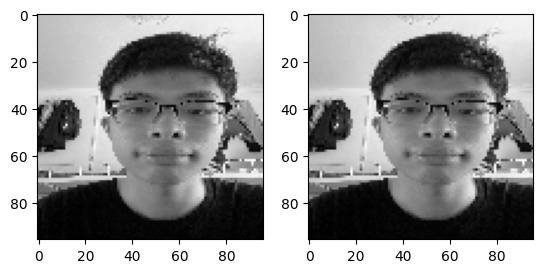

In [ ]:
for pair, y in generator(X_test, y_test):
  y_pred = model.predict(pair)
  print('Batch_size: ', len(y))
  idx = np.random.choice(range(len(y)))
  print('Pair label:', y[idx])
  print('Distance:', y_pred[idx])

  f1 = cnn(pair[0])
  f2 = cnn(pair[1])
  d = np.sqrt(np.sum((f1-f2)**2,axis = 1, keepdims = True))
  print('Distance by features:', d[idx])

  plt.subplot(121)
  plt.imshow(pair[0][idx].reshape(96,96),cmap = 'gray')
  plt.subplot(122)
  plt.imshow(pair[1][idx].reshape(96,96),cmap = 'gray')
  break

**Visualize new feature space**

In [ ]:
f = cnn.predict(X_test/255.)
p = plt.scatter(f[:,0],f[:,1], c = y_test, s=1)
plt.colorbar(p)

**Save model**

In [ ]:
cnn.save('cnn_loss1.h5')

**Load model and test**

In [ ]:
from tensorflow.keras.models import load_model
m = load_model('cnn_loss1.h5')

f1 = m.predict(X_test / 255.)
p = plt.scatter(f1[:,0],f1[:,1],c=y_test,s=1)
plt.colorbar(p)

**Visualize negative distance and positive distance**

In [ ]:
i = 0
y_true = []
y_pred = []
for pair,y in generator(X_test,y_test):
  f1 = cnn(pair[0])
  f2 = cnn(pair[1])
  d = np.sqrt(np.sum((f1 - f2)**2, axis = 1, keepdims = True))
  y_pred +=list(d.ravel())
  y_true +=list(y)
  i+=1
  if i>500:
    break

**Plot histogram**

(array([0.02634509, 0.10031626, 0.17699612, 0.22444551, 0.25864591,
        0.28979592, 0.26608888, 0.25474781, 0.22733087, 0.17763216,
        0.15015638, 0.11891207, 0.0917426 , 0.05465692, 0.03801606,
        0.02003263, 0.01449747, 0.00660688, 0.00369797, 0.00104815]),
 array([0.01694522, 0.41667154, 0.81639785, 1.21612418, 1.61585057,
        2.01557684, 2.41530323, 2.81502962, 3.21475577, 3.61448216,
        4.01420832, 4.41393471, 4.8136611 , 5.21338749, 5.61311388,
        6.01284027, 6.41256666, 6.81229258, 7.21201897, 7.61174536,
        8.01147175]),
 <BarContainer object of 20 artists>)

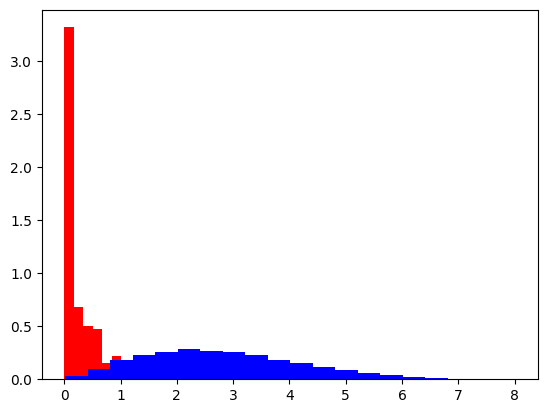

In [ ]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

positive_distances = y_pred[y_true == 1]
negative_distances = y_pred[y_true == 0]

plt.hist(positive_distances, color = 'r', density = True, bins = 20)
plt.hist(negative_distances, color = 'b', density = True, bins = 20)

**Check report using sklearn**

In [ ]:
thresh = 0.5
y_pred_ = y_pred < thresh
y_pred_.astype('uint8')
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_))

              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88    212424
         1.0       0.98      0.75      0.85    212424

    accuracy                           0.87    424848
   macro avg       0.89      0.87      0.87    424848
weighted avg       0.89      0.87      0.87    424848

